In [1]:
%load_ext autoreload
%autoreload 2


In [3]:
import sys
import os
import torch
import numpy as np
import torch.nn as nn
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from typing import Dict, List, Tuple, Optional


from src.utils.utils import lp_error
from src.utils.logger import Logging
from src.utils.colors import model_color

from src.nn.tanh import MLP
from src.nn.bspline import KAN
from src.utils.utils import clear_gpu_memory
from src.data.IBM_data_loader import load_fluid_testing_dataset
from src.utils.plot_losses import plot_M1_loss_history
from src.utils.fsi_visualization import (
    create_frames,
    create_animations_from_existing_frames,
)

from src.utils.ContourPlotter import ContourPlotter

In [4]:

CHECKPOINT_PATH = "./checkpoints/testing"
logger = Logging(CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

logger.print(model_dirname)

clear_gpu_memory()
config = {
    "dataset_type": "old",
    "training_selection_method": "Sobol",
    "input_dim": 3,  # (x, y, t)
    "hidden_dim": 250,
    "hidden_layers_dim": 3,
    "fluid_density": 1.0,
    "fluid_viscosity": 0.01,
    "num_epochs": 60000,
    "batch_size": 256,
    "learning_rate": 1e-3,
    "data_weight": 2.0,
    "physics_weight": 0.01,
    "boundary_weight": 2.0,
    "fsi_weight": 0.5,
    "initial_weight": 4.0,
    "checkpoint_dir": CHECKPOINT_PATH,
    "print_every": 500,
    "save_every": 2000,
    "fluid_sampling_ratio": 0.01,
    "interface_sampling_ratio": 0.07,
    "solid_sampling_ratio": 0.0,
    "left_sampling_ratio": 0.1,
    "right_sampling_ratio": 0.15,
    "bottom_sampling_ratio": 0.1,
    "top_sampling_ratio": 0.1,
    "initial_sampling_ratio": 0.1,
    "device":  "cpu",
    "solver": "mlp",
    "model": "m2",
}


INFO:src.utils.logger:./checkpoints/testing/2025-08-19_22-23-11-768056


GPU memory cleared!


INFO:src.utils.logger:Number of parameters: 182703
/home/afrah/ubuntu/afrah/code/pinn_fsi_ibm/src/utils/plot_losses.py:139: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=y_min)


final loss BC: 1.38e-02
final loss Physics: 1.06e-02
final loss FSI: 2.26e-05
final loss Initial: 7.62e-04


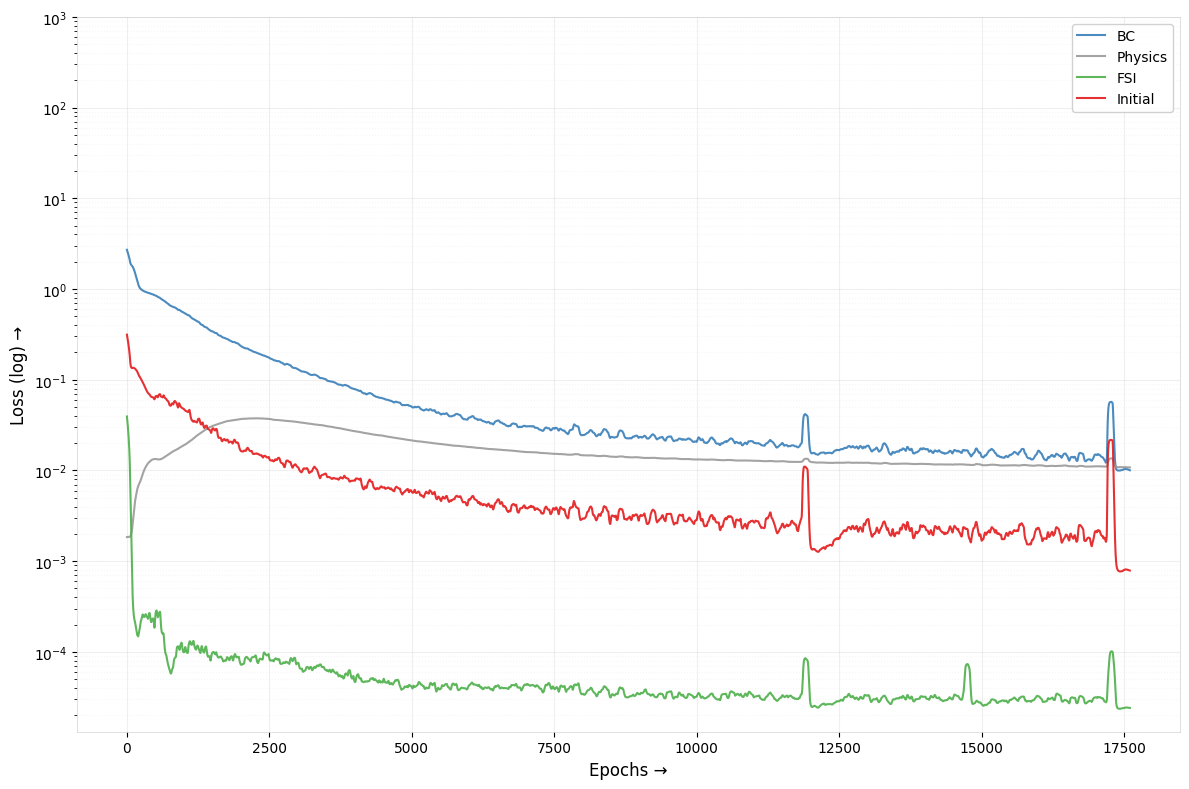

In [5]:
model_path = "./checkpoints/2025-08-19_03-45-33-735120/model.pth"#"./checkpoints/2025-08-17_00-29-12-363506/model.pth"#"./checkpoints/2025-08-17_00-25-12-195486/model.pth"#"./checkpoints/2025-08-16_18-14-52-209563/model.pth"#"./checkpoints/2025-08-15_19-40-16-627572/model.pth" #./checkpoints/2025-08-15_14-35-00-873250/model.pth

model_state = torch.load(model_path, map_location=config["device"])

if model_state["solver"] == "mlp":
    fluid_model = MLP(model_state["fluid_network"]).to(config["device"])
    solid_model = MLP(model_state["fluid_network"]).to(config["device"])
else:
    fluid_model = KAN(model_state["fluid_network"]).to(config["device"])
    solid_model = KAN(model_state["fluid_network"]).to(config["device"])


fluid_model.load_state_dict(model_state["fluid_model_state_dict"])
solid_model.load_state_dict(model_state["fluid_model_state_dict"])

fluid_model.eval()
solid_model.eval()

logger.print(
    f"Number of parameters: {sum(p.numel() for p in fluid_model.parameters())}"
)

loss_history = model_state["loss_history"]

save_path = os.path.join(logger.get_output_dir(), "loss_history_M1.png")

plot_M1_loss_history(loss_history, save_path, y_max=1000, y_min=0, figsize=(12, 8))

In [6]:


animations_reference_dir = os.path.join(logger.get_output_dir(), "animations_reference")

try:
    testing_dataset = load_fluid_testing_dataset(config["dataset_type"])
except Exception as e:
    logger.print(f"Testing dataset not found.")
    raise e

skip = 1
time = testing_dataset[:, 0:1][::skip]
x = testing_dataset[:, 1:2][::skip]
y = testing_dataset[:, 2:3][::skip]
u_ref = testing_dataset[:, 3:4][::skip]
v_ref = testing_dataset[:, 4:5][::skip]
p_ref = testing_dataset[:, 5:6][::skip]


with torch.no_grad():
    outputs = fluid_model(torch.cat([time, x, y], dim=1).squeeze(1))

u_pred = outputs[:, 0:1]
v_pred = outputs[:, 1:2]
p_pred = outputs[:, 2:3]


velocity_magnitude_pred = torch.sqrt(u_pred**2 + v_pred**2)

rel_u_l2_error = (
    torch.sqrt(torch.mean((u_pred - u_ref) ** 2) / torch.mean(u_ref**2)) * 100
)
rel_v_l2_error = (
    torch.sqrt(torch.mean((v_pred - v_ref) ** 2) / torch.mean(v_ref**2)) * 100
)
rel_p_l2_error = (
    torch.sqrt(torch.mean((p_pred - p_ref) ** 2) / torch.mean(p_ref**2)) * 100
)

logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")



INFO:src.utils.logger:Relative L2 error for u: 1.61e+01 %
INFO:src.utils.logger:Relative L2 error for v: 2.78e+01 %
INFO:src.utils.logger:Relative L2 error for p: 2.58e+01 %


In [ ]:
INFO:src.utils.logger:Relative L2 error for u: 1.78e+01 %
INFO:src.utils.logger:Relative L2 error for v: 2.91e+01 %
INFO:src.utils.logger:Relative L2 error for p: 3.29e+01 %

SyntaxError: invalid syntax (1378702981.py, line 1)

In [ ]:
processed_dataset_path = "./data/Fluid_trainingData.mat"
Fluid_data = scipy.io.loadmat(processed_dataset_path)

interface = Fluid_data["Solid_interface"]
solid = Fluid_data["Solid_points"]

with torch.no_grad():
    outputs_interface_m1 = np.array(
        solid_model(
            torch.cat(
                [
                    torch.tensor(interface[:, 0:1], dtype=torch.float32),
                    torch.tensor(interface[:, 1:2], dtype=torch.float32),
                    torch.tensor(interface[:, 2:3], dtype=torch.float32),
                ],
                dim=1,
            ).squeeze(1)
        ).detach().numpy()
    )

u_pred_interface_m1 = outputs_interface_m1[:, 0:1]
v_pred_interface_m1 = outputs_interface_m1[:, 1:2]
p_pred_interface_m1 = outputs_interface_m1[:, 2:3]


logger.print(f"On the interface")

rel_u_l2_error = (
    np.sqrt(
        np.mean((u_pred_interface_m1 - np.array(interface[:, 3:4])) ** 2)
        / np.mean(np.array(interface[:, 3:4]) ** 2)
    )
    * 100
)

rel_v_l2_error = (
    np.sqrt(
        np.mean((v_pred_interface_m1 - np.array(interface[:, 4:5])) ** 2)
        / np.mean(np.array(interface[:, 4:5]) ** 2)
    )
    * 100
)

rel_p_l2_error = (
    np.sqrt(
        np.mean((p_pred_interface_m1 - np.array(interface[:, 5:6])) ** 2)
        / np.mean(np.array(interface[:, 5:6]) ** 2)
    )
    * 100
)


logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")


INFO:src.utils.logger:On the interface
INFO:src.utils.logger:Relative L2 error for u: 3.84e+01 %
INFO:src.utils.logger:Relative L2 error for v: 3.90e+01 %
INFO:src.utils.logger:Relative L2 error for p: 7.27e+01 %


In [ ]:
INFO:src.utils.logger:On the interface
INFO:src.utils.logger:Relative L2 error for u: 3.54e+01 %
INFO:src.utils.logger:Relative L2 error for v: 3.92e+01 %
INFO:src.utils.logger:Relative L2 error for p: 7.29e+01 %

### Prediction on the Solid

In [ ]:

with torch.no_grad():
    outputs_solid_m1 = np.array(
        solid_model(
            torch.cat(
                [
                    torch.tensor(solid[:, 0:1], dtype=torch.float32),
                    torch.tensor(solid[:, 1:2], dtype=torch.float32),
                    torch.tensor(solid[:, 2:3], dtype=torch.float32),
                ],
                dim=1,
            ).squeeze(1)
        ).detach().numpy()
    )

u_pred_solid_m1 = outputs_solid_m1[:, 0:1]
v_pred_solid_m1 = outputs_solid_m1[:, 1:2]
p_pred_solid_m1 = outputs_solid_m1[:, 2:3]


logger.print(f"On the Solid")

rel_u_l2_error = (
    np.sqrt(
        np.mean((u_pred_solid_m1 - np.array(solid[:, 3:4])) ** 2)
        / np.mean(np.array(solid[:, 3:4]) ** 2)
    )
    * 100
)

rel_v_l2_error = (
    np.sqrt(
        np.mean((v_pred_solid_m1 - np.array(solid[:, 4:5])) ** 2)
        / np.mean(np.array(solid[:, 4:5]) ** 2)
    )
    * 100
)

rel_p_l2_error = (
    np.sqrt(
        np.mean((p_pred_solid_m1 - np.array(solid[:, 5:6])) ** 2)
        / np.mean(np.array(solid[:, 5:6]) ** 2)
    )
    * 100
)


logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")


INFO:src.utils.logger:On the Solid
INFO:src.utils.logger:Relative L2 error for u: 2.74e+01 %
INFO:src.utils.logger:Relative L2 error for v: 3.35e+01 %
INFO:src.utils.logger:Relative L2 error for p: 6.49e+01 %


In [ ]:
INFO:src.utils.logger:On the Solid
INFO:src.utils.logger:Relative L2 error for u: 2.74e+01 %
INFO:src.utils.logger:Relative L2 error for v: 3.35e+01 %
INFO:src.utils.logger:Relative L2 error for p: 6.49e+01 %

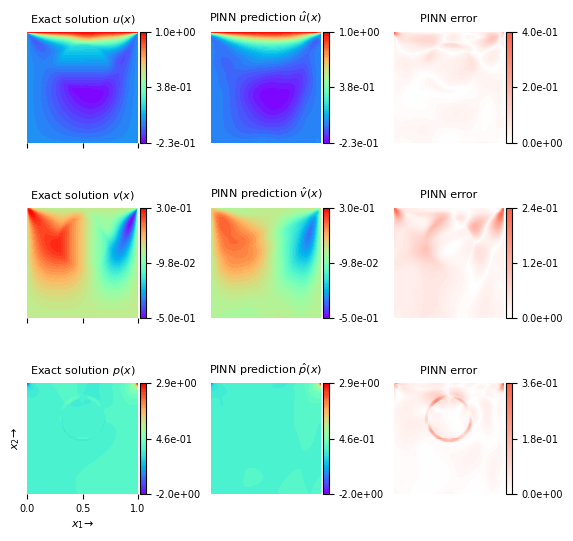

In [ ]:



class CavityFlowAnalyzer:
    def __init__(self, logger, device: torch.device):
        self.logger = logger
        self.device = device
        self.results = {}

    def load_data(
        self, data_path: str, tstep: int, xstep: int, ystep: int, skip: int
    ) -> None:
        """Load and preprocess cavity flow data."""
        domain = testing_dataset

        # Reshape and skip data points
        self.time_ = (
            domain[:, 0:1]
            .reshape(tstep, xstep, ystep)[:, ::skip, ::skip]
            .reshape(-1, 1)
        )
        self.xfa = (
            domain[:, 1:2]
            .reshape(tstep, xstep, ystep)[:, ::skip, ::skip]
            .reshape(-1, 1)
        )
        self.yfa = (
            domain[:, 2:3]
            .reshape(tstep, xstep, ystep)[:, ::skip, ::skip]
            .reshape(-1, 1)
        )
        self.ufa = (
            domain[:, 3:4]
            .reshape(tstep, xstep, ystep)[:, ::skip, ::skip]
            .reshape(-1, 1)
        )
        self.vfa = (
            domain[:, 4:5]
            .reshape(tstep, xstep, ystep)[:, ::skip, ::skip]
            .reshape(-1, 1)
        )
        self.pfa = (
            domain[:, 5:6]
            .reshape(tstep, xstep, ystep)[:, ::skip, ::skip]
            .reshape(-1, 1)
        )
        self.u_pred = (
            u_pred
            .reshape(tstep, xstep, ystep)[:, ::skip, ::skip]
            .reshape(-1, 1)
        )
        self.v_pred = (
            v_pred
            .reshape(tstep, xstep, ystep)[:, ::skip, ::skip]
            .reshape(-1, 1)
        )
        self.p_pred = (
            p_pred
            .reshape(tstep, xstep, ystep)[:, ::skip, ::skip]
            .reshape(-1, 1)
        )
        self.new_shape = (
            domain[:, 0:1].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].shape
        )

    def reshape_results(self) -> Dict[str, np.ndarray]:
        """Reshape all results for visualization."""
        tstep, xstep, ystep = self.new_shape

        # Helper function to convert tensor to numpy if needed
        def to_numpy(data):
            if hasattr(data, 'detach'):  # PyTorch tensor
                return data.detach().cpu().numpy()
            return np.array(data) if not isinstance(data, np.ndarray) else data

        reshaped_data = {
            "tf": to_numpy(self.time_).reshape(tstep, xstep, ystep),
            "xf": to_numpy(self.xfa).reshape(tstep, xstep, ystep),
            "yf": to_numpy(self.yfa).reshape(tstep, xstep, ystep),
            "exact_u": to_numpy(self.ufa).reshape(tstep, xstep, ystep),
            "exact_v": to_numpy(self.vfa).reshape(tstep, xstep, ystep),
            "exact_p": to_numpy(self.pfa).reshape(tstep, xstep, ystep),
            "u_pred": to_numpy(self.u_pred).reshape(tstep, xstep, ystep),
            "v_pred": to_numpy(self.v_pred).reshape(tstep, xstep, ystep),
            "p_pred": to_numpy(self.p_pred).reshape(tstep, xstep, ystep),
            # Calculate errors
            "error_u": to_numpy(np.abs(to_numpy(self.ufa) - to_numpy(self.u_pred))).reshape(tstep, xstep, ystep),
            "error_v": to_numpy(np.abs(to_numpy(self.vfa) - to_numpy(self.v_pred))).reshape(tstep, xstep, ystep),
            "error_p": to_numpy(np.abs(to_numpy(self.pfa) - to_numpy(self.p_pred))).reshape(tstep, xstep, ystep), 
        }
        return reshaped_data

    def plot_time_series_for_variable(
        self, 
        variable_name: str, 
        time_steps: List[int], 
        transpose: bool = True,
        solution_type: str = "exact" , # "exact", "pred", or "error"
        draw_axis_ticks : bool = False
    ):
        reshaped_data = self.reshape_results()
        
        # Get the appropriate data key
        if solution_type == "exact":
            data_key = f"exact_{variable_name}"
            title_prefix = f"Exact solution ${variable_name}(x)$"
        elif solution_type == "pred":
            data_key = f"{variable_name}_pred"
            title_prefix = f"PINN prediction $\\hat{{{variable_name}}}(x)$"
        elif solution_type == "error":
            data_key = f"error_{variable_name}"
            title_prefix = f"PINN error ${variable_name}$"
        else:
            raise ValueError("solution_type must be 'exact', 'pred', or 'error'")
        
        variable_data = reshaped_data[data_key]
        
        if transpose:
            variable_data = variable_data.transpose(0, 2, 1)
        
        visualization_data = [variable_data for _ in time_steps]
        
        titles = [f"$t = {t}$" for t in time_steps]
        nrows_ncols = (1, len(time_steps))
        
        plotter = ContourPlotter(fontsize=8, labelsize=7, axes_pad=0.15)
        
        if transpose:
            xf_data = reshaped_data["yf"][0, 0, :]
            yf_data = reshaped_data["xf"][0, :, 0]
        else:
            xf_data = reshaped_data["xf"][0, :, 0]
            yf_data = reshaped_data["yf"][0, 0, :]
        
        plotter.draw_contourf_time_series(
            reshaped_data["tf"][:, 0, 0],
            xf_data,
            yf_data,
            visualization_data,
            titles=titles,
            nrows_ncols=nrows_ncols,
            time_steps=time_steps,
            model_dirname=self.logger.get_output_dir(),
            img_width=1.5 * len(time_steps),  # Adjust width based on number of time steps
            img_height=6,
            ticks=3,
            variable_name=variable_name,
            solution_type=solution_type,
            draw_axis_ticks= draw_axis_ticks
        )


analyzer = CavityFlowAnalyzer(logger, config["device"])

data_path = "./data/IB_PINN3.mat"
analyzer.load_data(data_path, tstep=101, xstep=102, ystep=102, skip=1)



reshaped_data = analyzer.reshape_results()
titles = [
    "Exact solution $u(x)$",
    "PINN prediction $\\hat{u}(x)$",
    "PINN error",
    "Exact solution $v(x)$",
    "PINN prediction $\\hat{v}(x)$",
    "PINN error",
    "Exact solution $p(x)$",
    "PINN prediction $\\hat{p}(x)$",
    "PINN error",
]
nrows_ncols = (3, 3)
values = [99]
xref = 1
yref = 1
model_dirname = logger.get_output_dir()
img_width = 30
img_height = 6
ticks = 3

visualization_data = [
    reshaped_data["exact_u"].transpose(0, 2, 1),  # swap x and y dimensions
    reshaped_data["u_pred"].transpose(0, 2, 1),
    reshaped_data["error_u"].transpose(0, 2, 1),
    reshaped_data["exact_v"].transpose(0, 2, 1),
    reshaped_data["v_pred"].transpose(0, 2, 1),
    reshaped_data["error_v"].transpose(0, 2, 1),
    reshaped_data["exact_p"].transpose(0, 2, 1),
    reshaped_data["p_pred"].transpose(0, 2, 1),
    reshaped_data["error_p"].transpose(0, 2, 1),
]

plotter = ContourPlotter(fontsize=8, labelsize=7, axes_pad=0.65)

plotter.draw_contourf_regular_2D(
    reshaped_data["tf"][:, 0, 0],
    reshaped_data["yf"][0, 0, :],
    reshaped_data["xf"][0, :, 0],
    visualization_data,
    titles=titles,
    nrows_ncols=nrows_ncols,
    time_steps=values,
    xref=xref,
    yref=yref,
    model_dirname=model_dirname,
    img_width=img_width,
    img_height=img_height,
    ticks=ticks,
)



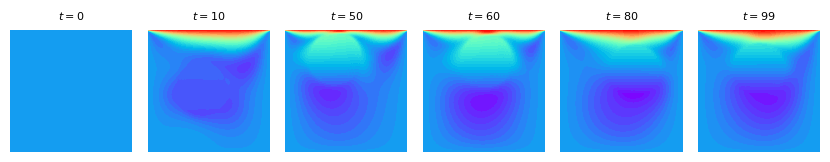

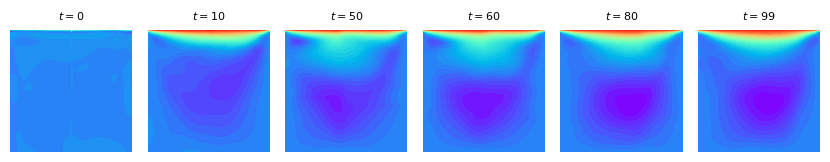

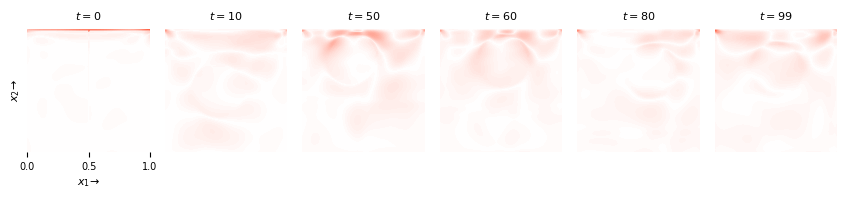

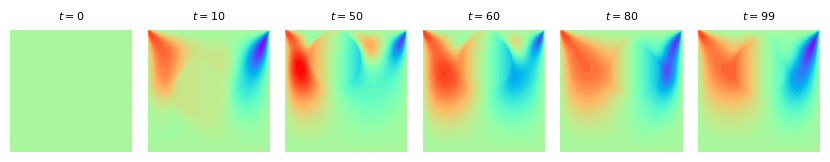

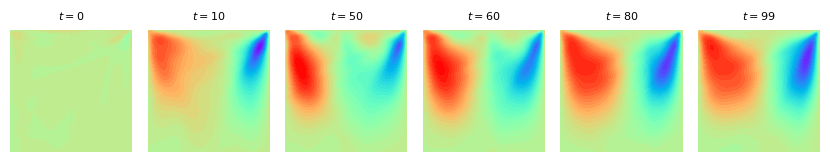

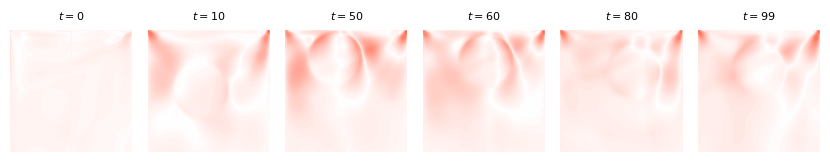

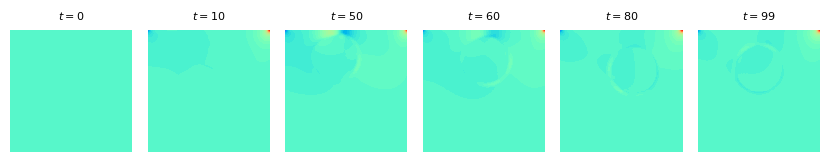

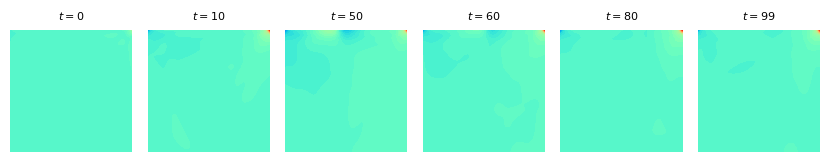

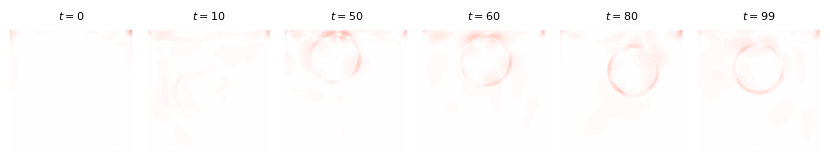

In [ ]:



# Usage example:
analyzer = CavityFlowAnalyzer(logger, config["device"])
data_path = "./data/IB_PINN3.mat"
analyzer.load_data(data_path, tstep=101, xstep=102, ystep=102, skip=1)

# Plot time series for u variable (exact solution)
time_steps = [0, 10, 50, 60, 80, 99]  # Specify which time steps to plot
analyzer.plot_time_series_for_variable(
    variable_name="u", 
    time_steps=time_steps,
    transpose=True,
    solution_type="exact",
    draw_axis_ticks = False
)

# Plot time series for u variable (predictions)
analyzer.plot_time_series_for_variable(
    variable_name="u", 
    time_steps=time_steps,
    transpose=True,
    solution_type="pred",
    draw_axis_ticks = False

)

# Plot time series for u variable (errors)
analyzer.plot_time_series_for_variable(
    variable_name="u", 
    time_steps=time_steps,
    transpose=True,
    solution_type="error",
    draw_axis_ticks = True
)

# You can also plot for v and p variables:
analyzer.plot_time_series_for_variable("v", time_steps, transpose=True, solution_type="exact")
analyzer.plot_time_series_for_variable("v", time_steps, transpose=True, solution_type="pred")
analyzer.plot_time_series_for_variable("v", time_steps, transpose=True, solution_type="error")

analyzer.plot_time_series_for_variable("p", time_steps, transpose=True, solution_type="exact")
analyzer.plot_time_series_for_variable("p", time_steps, transpose=True, solution_type="pred")
analyzer.plot_time_series_for_variable("p", time_steps, transpose=True, solution_type="error")



In [ ]:
p_pred.shape

torch.Size([1050804, 1])

In [ ]:


animations_pred_dir = os.path.join(logger.get_output_dir(), "animations_pred")

prediction_df = pd.DataFrame(
    {
        "time": time.detach().numpy().flatten(),
        "x": x.detach().numpy().flatten(),
        "y": y.detach().numpy().flatten(),
        "pressure": p_pred.detach().numpy().flatten(),
        "u_x": u_pred.detach().numpy().flatten(),
        "v_y": v_pred.detach().numpy().flatten(),
        "velocity_magnitude": np.sqrt(
            u_pred.detach().numpy().flatten() ** 2
            + v_pred.detach().numpy().flatten() ** 2
        ),
    }
)

create_frames(prediction_df, output_dir=animations_pred_dir, sample_rate=10)


testing_df = pd.DataFrame(
    {
        "time": time.detach().numpy().flatten(),
        "x": x.detach().numpy().flatten(),
        "y": y.detach().numpy().flatten(),
        "pressure": p_ref.detach().numpy().flatten(),
        "u_x": u_ref.detach().numpy().flatten(),
        "v_y": v_ref.detach().numpy().flatten(),
        "velocity_magnitude": np.sqrt(
            u_ref.detach().numpy().flatten() ** 2
            + v_ref.detach().numpy().flatten() ** 2
        ),
    }
)
create_frames(testing_df, output_dir=animations_reference_dir, sample_rate=10)

create_animations_from_existing_frames(
    frames_dirs=[
        os.path.join(animations_reference_dir, "pressure"),
        os.path.join(animations_reference_dir, "u_x"),
        os.path.join(animations_reference_dir, "v_y"),
        os.path.join(animations_reference_dir, "velocity_magnitude"),
    ],
    output_dir=os.path.join(animations_reference_dir, "gif"),
)
create_animations_from_existing_frames(
    frames_dirs=[
        os.path.join(animations_pred_dir, "pressure"),
        os.path.join(animations_pred_dir, "u_x"),
        os.path.join(animations_pred_dir, "v_y"),
        os.path.join(animations_pred_dir, "velocity_magnitude"),
    ],
    output_dir=os.path.join(animations_pred_dir, "gif"),
)


  Processing time step 0.00 (1/11)
  Processing time step 0.10 (2/11)
  Processing time step 0.20 (3/11)
  Processing time step 0.30 (4/11)
  Processing time step 0.40 (5/11)
  Processing time step 0.50 (6/11)
  Processing time step 0.60 (7/11)
  Processing time step 0.70 (8/11)
  Processing time step 0.80 (9/11)
  Processing time step 0.90 (10/11)
  Processing time step 1.00 (11/11)
Saved frames to ./checkpoints/testing/2025-08-15_18-19-15-436724/animations_pred/pressure
  Processing time step 0.00 (1/11)
  Processing time step 0.10 (2/11)
  Processing time step 0.20 (3/11)
  Processing time step 0.30 (4/11)
  Processing time step 0.40 (5/11)
  Processing time step 0.50 (6/11)
  Processing time step 0.60 (7/11)
  Processing time step 0.70 (8/11)
  Processing time step 0.80 (9/11)
  Processing time step 0.90 (10/11)
  Processing time step 1.00 (11/11)
Saved frames to ./checkpoints/testing/2025-08-15_18-19-15-436724/animations_pred/velocity_magnitude
  Processing time step 0.00 (1/11)
 